#### CSCE 670 :: Information Storage and Retrieval :: Texas A&M University :: Spring 2020


# Scrapy
By Feiyan Yu

## Introduction

Scrapy is an application framework for crawling web sites and extracting structured data which can be used for a wide range of useful applications, like data mining, information processing or historical archival.

Even though Scrapy was originally designed for web scraping, it can also be used to extract data using APIs (such as Amazon Associates Web Services) or as a general purpose web crawler.


## Install  Guide

`conda install -c conda-forge scrapy` or `pip install Scrapy`

## Architecture

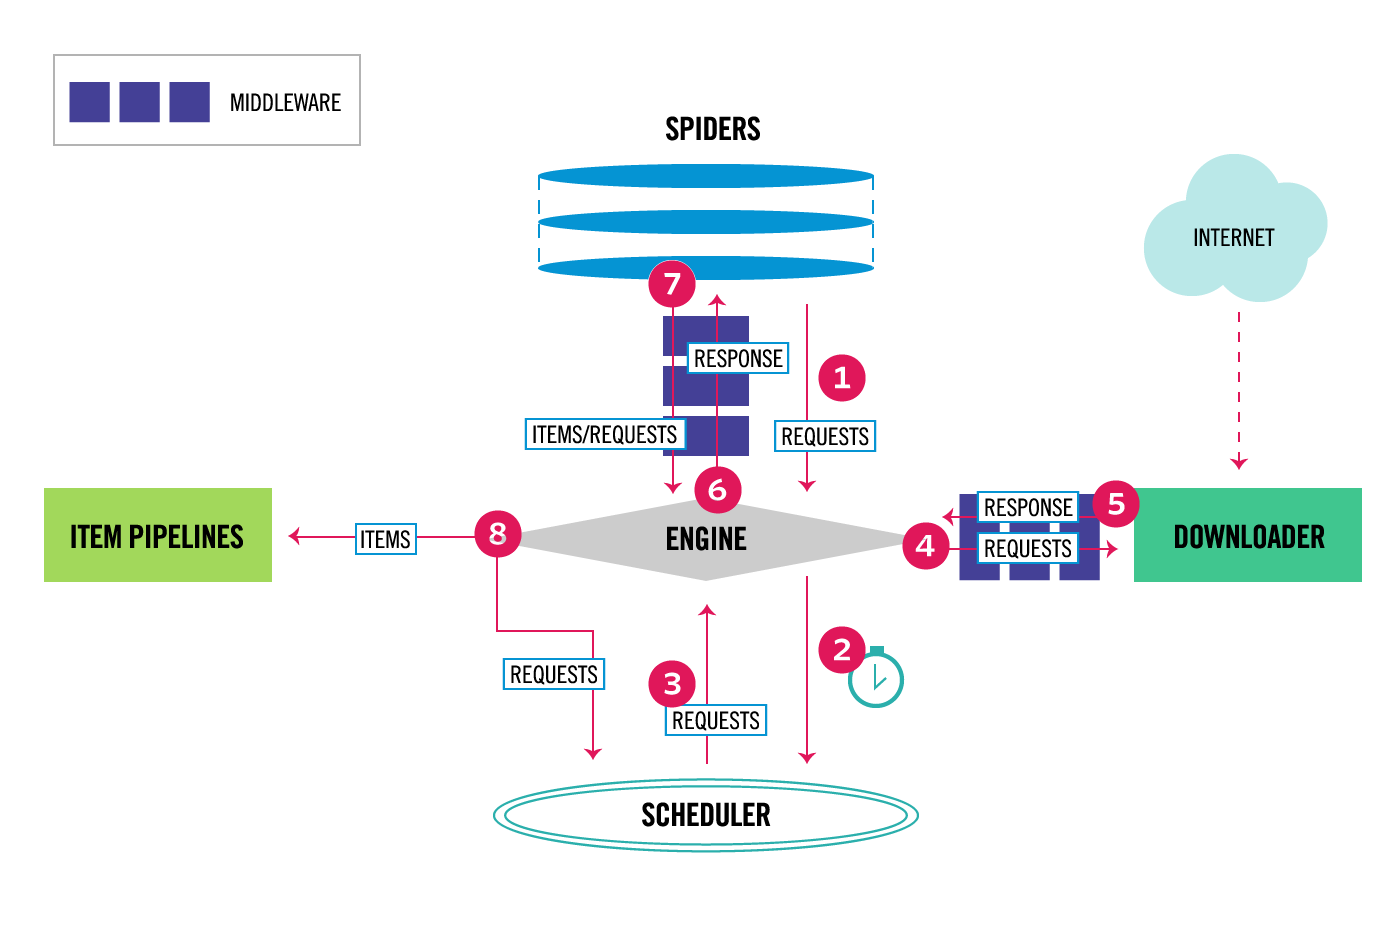

##### The data flow in Scrapy is controlled by the execution engine, and goes like this:

1. The Engine gets the initial Requests to crawl from the Spider.
The Engine schedules the Requests in the Scheduler and asks for the next Requests to crawl.
2. The Scheduler returns the next Requests to the Engine.
3. The Engine sends the Requests to the Downloader, passing through the Downloader 4. Middlewares (see process_request()).
5. Once the page finishes downloading the Downloader generates a Response (with that page) and sends it to the Engine, passing through the Downloader Middlewares (see process_response()).
6. The Engine receives the Response from the Downloader and sends it to the Spider for processing, passing through the Spider Middleware (see process_spider_input()).
7. The Spider processes the Response and returns scraped items and new Requests (to follow) to the Engine, passing through the Spider Middleware (see process_spider_output()).
8. The Engine sends processed items to Item Pipelines, then send processed Requests to the Scheduler and asks for possible next Requests to crawl.
9. The process repeats (from step 1) until there are no more requests from the Scheduler.

#### Spiders is the core part to get customized scrape
Spiders are classes which define how a certain site (or a group of sites) will be scraped, including how to perform the crawl (i.e. follow links) and how to extract structured data from their pages (i.e. scraping items). In other words, Spiders are the place where you define the custom behaviour for crawling and parsing pages for a particular site (or, in some cases, a group of sites).

#### To do that, we need to define a scrapy class with the following elements:
1. inherit from `class scrapy.spider.Spider`
2. `name`: A string which defines the name for this spider. The spider name is how the spider is located (and instantiated) by Scrapy, so it must be unique. However, nothing prevents you from instantiating more than one instance of the same spider. This is the most important spider attribute and it’s required.
3. `start_urls`: A list of URLs where the spider will begin to crawl from, when no particular URLs are specified. So, the first pages downloaded will be those listed here. The subsequent Request will be generated successively from data contained in the start URLs.
4. `parse:` This is the default callback used by Scrapy to process downloaded responses, when their requests don’t specify a callback. The parse method is in charge of processing the response and returning scraped data and/or more URLs to follow. Other Requests callbacks have the same requirements as the Spider class. This method, as well as any other Request callback, must return an iterable of Request and/or dicts or Item objects.
5. ......etc

### 🐛 Important Issue about Scrapy on Jupyter Notebook
1. Normally, we don't use Scrapy on the jupyter-notebook. Instead, we create a Scrapy project and run it by command line, which is better to separate every part clear. However, I just user jupyter-notebook here.
2. When creating the 'CrawlerProcess' on jupyter-notebook, there is a bug called 'Reactor not Restartable' because of the inner realization of scrapy is on the top of Twisted reactor which is not restartable. And to deal with that, we need to create multiprocess for 2 examples. That is complicated and not the concentration in this spotlight. So, my method is to restart the kernel for each example. 

## An Example of Scrapy

This is a simple example of scrapy that get data from [http://quotes.toscrape.com/tag/humor/](http://quotes.toscrape.com/tag/humor/) that has all quotes with tag humor.

In [1]:
import scrapy
from scrapy.crawler import CrawlerProcess

# your spider
class QuotesSpider(scrapy.Spider):
    name = "quotes"
    start_urls = ['http://quotes.toscrape.com/tag/humor/']

    def parse(self, response):
        for quote in response.css('div.quote'):
            print(quote.css('span.text::text').extract_first())

In [2]:
process = CrawlerProcess(settings={
    'FEED_FORMAT': 'json',
    'FEED_URI': 'items.json'
})

process.crawl(QuotesSpider)
process.start()

2020-03-30 00:11:50 [scrapy.utils.log] INFO: Scrapy 2.0.1 started (bot: scrapybot)
2020-03-30 00:11:50 [scrapy.utils.log] INFO: Versions: lxml 4.5.0.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.5.2, w3lib 1.20.0, Twisted 20.3.0, Python 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)], pyOpenSSL 19.1.0 (OpenSSL 1.1.1e  17 Mar 2020), cryptography 2.8, Platform Windows-10-10.0.18362-SP0
2020-03-30 00:11:50 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.selectreactor.SelectReactor
2020-03-30 00:11:50 [scrapy.crawler] INFO: Overridden settings:
{'FEED_FORMAT': 'json', 'FEED_URI': 'items.json'}
2020-03-30 00:11:50 [scrapy.extensions.telnet] INFO: Telnet Password: 542341cfd5186b6d
2020-03-30 00:11:50 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.logstats.LogStats']
2020-03-30 00:11:50 [scrapy.middleware] INFO: Enabl

“The person, be it gentleman or lady, who has not pleasure in a good novel, must be intolerably stupid.”
“A day without sunshine is like, you know, night.”
“Anyone who thinks sitting in church can make you a Christian must also think that sitting in a garage can make you a car.”
“Beauty is in the eye of the beholder and it may be necessary from time to time to give a stupid or misinformed beholder a black eye.”
“All you need is love. But a little chocolate now and then doesn't hurt.”
“Remember, we're madly in love, so it's all right to kiss me anytime you feel like it.”
“Some people never go crazy. What truly horrible lives they must lead.”
“The trouble with having an open mind, of course, is that people will insist on coming along and trying to put things in it.”
“Think left and think right and think low and think high. Oh, the thinks you can think up if only you try!”
“The reason I talk to myself is because I’m the only one whose answers I accept.”


## What happened above?

We create a process to run the Scrapy and call the default callback method parse by using CSS Selector to extract quote element and print the content within the text anchor. You can find the original page and inspect it and find the structure.

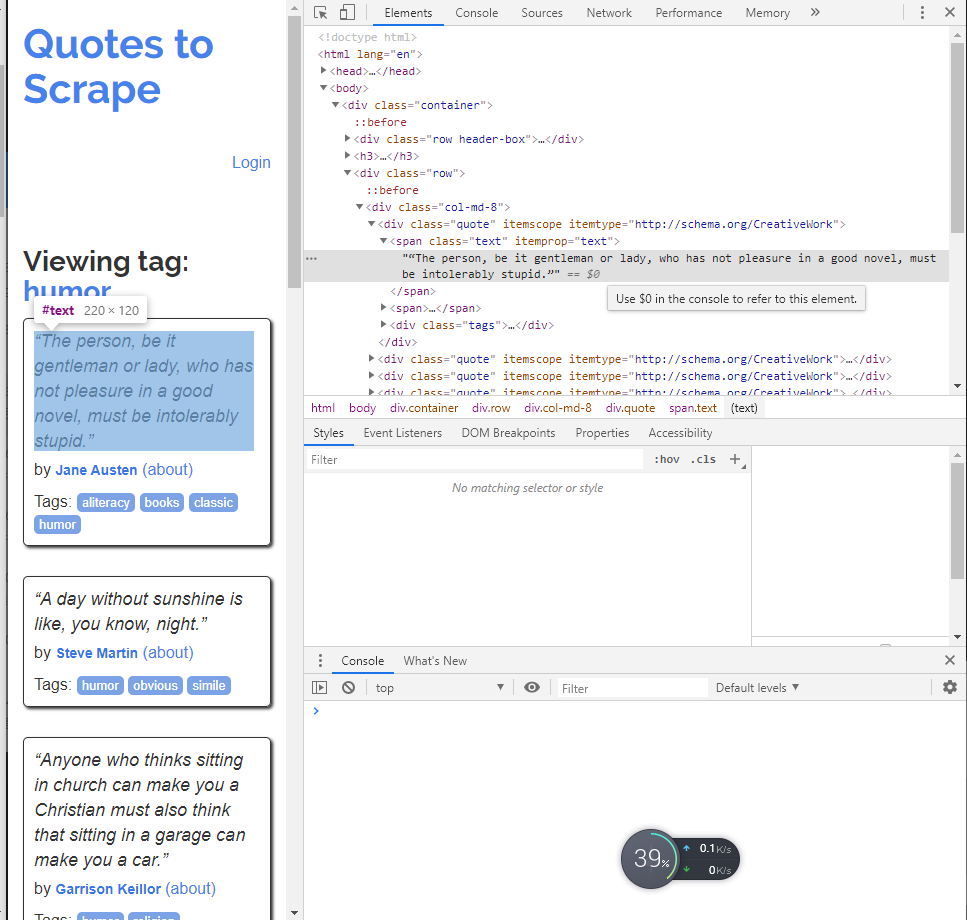

## A little complicated example for Scrapy -- Multiple pages

sometimes, some pages have been paginated and we want to get items for all pages. 
like this:
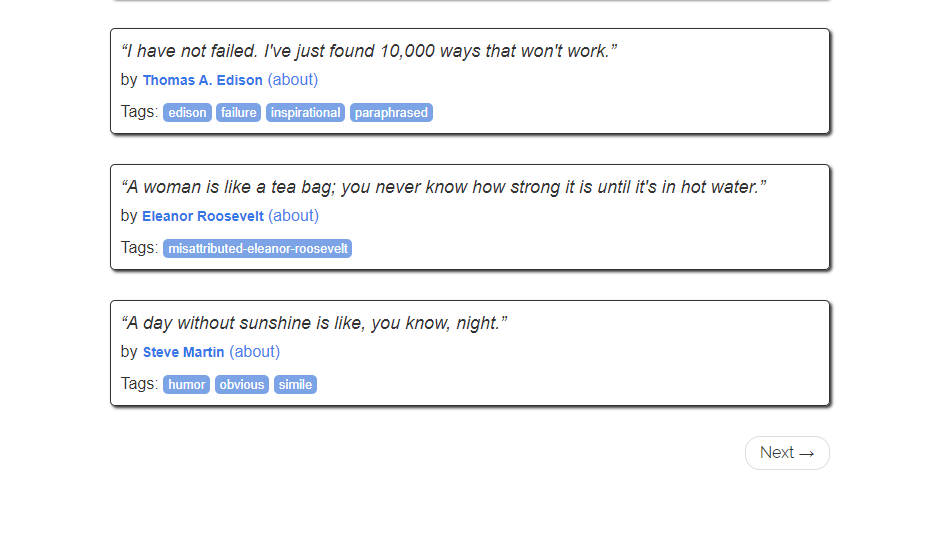
How to deal with that by using Scrapy? 

We use yield in python to return multiple times by checking the link of "Next Page" and recursively use parse function as callback.

In [3]:
import scrapy
from scrapy.crawler import CrawlerProcess

allQuote = []

class QuotesSpiderAllpages(scrapy.Spider):
    name = 'quotesAllpages'
    allowed_domains = ['quotes.toscrape.com']
    start_urls = ['http://quotes.toscrape.com/']

    def parse(self, response):
        quotes = response.css('div.quote')
        for quote in quotes:
            text = quote.css('span.text::text').extract_first()
            author = quote.css('small.author::text').extract_first()
            tags = quote.css('a.tag::text').extract()

            item = {
                'text': text,
                'author': author,
                'tags': tags
            }

            allQuote.append(item)

        next_page_url = response.css('li.next > a::attr(href)').extract_first()
        if next_page_url:
            next_page_url = response.urljoin(next_page_url)
            yield scrapy.Request(url=next_page_url, callback=self.parse)

In [4]:
process = CrawlerProcess(settings={
    'FEED_FORMAT': 'json',
    'FEED_URI': 'items.json'
})

process.crawl(QuotesSpiderAllpages)
process.start()

2020-03-25 14:37:08 [scrapy.utils.log] INFO: Scrapy 2.0.1 started (bot: scrapybot)
2020-03-25 14:37:08 [scrapy.utils.log] INFO: Versions: lxml 4.5.0.0, libxml2 2.9.5, cssselect 1.1.0, parsel 1.5.2, w3lib 1.21.0, Twisted 20.3.0, Python 3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 16:05:27) [MSC v.1900 64 bit (AMD64)], pyOpenSSL 19.1.0 (OpenSSL 1.1.1d  10 Sep 2019), cryptography 2.8, Platform Windows-10-10.0.18362-SP0
2020-03-25 14:37:08 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.selectreactor.SelectReactor
2020-03-25 14:37:08 [scrapy.crawler] INFO: Overridden settings:
{'FEED_FORMAT': 'json', 'FEED_URI': 'items.json'}
2020-03-25 14:37:08 [scrapy.extensions.telnet] INFO: Telnet Password: ef5bf1e794228097
2020-03-25 14:37:08 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.logstats.LogStats']
2020-03-25 14:37:08 [scrapy.middlew

We print our result, that is all quotes in http://quotes.toscrape.com/

In [6]:
for i, quote in enumerate(allQuote):
    print("quote", i + 1, quote)

quote 1 {'author': 'Albert Einstein', 'tags': ['change', 'deep-thoughts', 'thinking', 'world'], 'text': '“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”'}
quote 2 {'author': 'J.K. Rowling', 'tags': ['abilities', 'choices'], 'text': '“It is our choices, Harry, that show what we truly are, far more than our abilities.”'}
quote 3 {'author': 'Albert Einstein', 'tags': ['inspirational', 'life', 'live', 'miracle', 'miracles'], 'text': '“There are only two ways to live your life. One is as though nothing is a miracle. The other is as though everything is a miracle.”'}
quote 4 {'author': 'Jane Austen', 'tags': ['aliteracy', 'books', 'classic', 'humor'], 'text': '“The person, be it gentleman or lady, who has not pleasure in a good novel, must be intolerably stupid.”'}
quote 5 {'author': 'Marilyn Monroe', 'tags': ['be-yourself', 'inspirational'], 'text': "“Imperfection is beauty, madness is genius and it's better to be absolutel

## Exercise: Scrape url and write results to a JSON file
URL: https://www.imdb.com/chart/top/ It contains top 250 movies in IMDB.

#### Define the spider
The IMDBtop250Spider class defines from which URLs to start crawling and which values to retrieve. 

In [1]:
import scrapy
from scrapy.crawler import CrawlerProcess

class IMDBtop250Spider(scrapy.Spider):
    name = "imdptop250"
    # The scrapy.Request function takes the URL you want to crawl 
    def start_requests(self):
        url = "https://www.imdb.com/chart/top/"
        yield scrapy.Request(url=url, callback=self.parse)
    
    custom_settings = {
        'ITEM_PIPELINES': {'__main__.JsonWriterPipeline': 1}, 
        'FEED_FORMAT':'json',                                 
        'FEED_URI': 'quoteresult.json'                        
    }
    def parse(self, response):
        #At there we use xpath selector
        for row in response.xpath("//*[@id='main']/div/span/div/div/div[3]/table/tbody/tr"):
            yield {
                "movie": row.xpath("td[2]/a/text()").get(),
                "year" : row.xpath("td[2]/span/text()").get(),
                "rating": row.xpath("td[3]/strong/text()").get(),
            }

We also need to create a pipeline to write the return value to json file and use the `custom_settings` property to override ITEM_PIPELINES.

In [2]:
import json

class JsonWriterPipeline(object):

    def open_spider(self, spider):
        self.file = open('items.jl', 'w')

    def close_spider(self, spider):
        self.file.close()

    def process_item(self, item, spider):
        line = json.dumps(dict(item)) + "\n"
        self.file.write(line)
        return item

`process_item(self, item, spider)`
This method is called for every item pipeline component. process_item() must either: return a dict with data, return an Item (or any descendant class) object, return a Deferred or raise DropItem exception. Dropped items are no longer processed by further pipeline components.

Parameters:	
item (Item object or a dict) – the item scraped
spider (Spider object) – the spider which scraped the item
Additionally, they may also implement the following methods:

`open_spider(self, spider)`
This method is called when the spider is opened.

Parameters:	spider (Spider object) – the spider which was opened

`close_spider(self, spider)`
This method is called when the spider is closed.

Parameters:	spider (Spider object) – the spider which was closed

`from_crawler(cls, crawler)`
If present, this classmethod is called to create a pipeline instance from a Crawler. It must return a new instance of the pipeline. Crawler object provides access to all Scrapy core components like settings and signals; it is a way for pipeline to access them and hook its functionality into Scrapy.

In [3]:
process = CrawlerProcess()

process.crawl(IMDBtop250Spider)
process.start()

2020-03-24 21:25:20 [scrapy.utils.log] INFO: Scrapy 2.0.1 started (bot: scrapybot)
2020-03-24 21:25:20 [scrapy.utils.log] INFO: Versions: lxml 4.5.0.0, libxml2 2.9.5, cssselect 1.1.0, parsel 1.5.2, w3lib 1.21.0, Twisted 20.3.0, Python 3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 16:05:27) [MSC v.1900 64 bit (AMD64)], pyOpenSSL 19.1.0 (OpenSSL 1.1.1d  10 Sep 2019), cryptography 2.8, Platform Windows-10-10.0.18362-SP0
2020-03-24 21:25:20 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.selectreactor.SelectReactor
2020-03-24 21:25:20 [scrapy.crawler] INFO: Overridden settings:
{'FEED_FORMAT': 'json', 'FEED_URI': 'quoteresult.json'}
2020-03-24 21:25:21 [scrapy.extensions.telnet] INFO: Telnet Password: b9848171ae3b6fb7
2020-03-24 21:25:21 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.logstats.LogStats',
 'scrapy.extensions.feedexport.FeedExporter']
2020-03-24 21:25:21 [scrapy.m

2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(1998)', 'movie': 'American History X', 'rating': '8.5'}
2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(1991)', 'movie': 'Terminator 2: Judgment Day', 'rating': '8.5'}
2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(2002)', 'movie': 'The Pianist', 'rating': '8.5'}
2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(1985)', 'movie': 'Back to the Future', 'rating': '8.5'}
2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(1936)', 'movie': 'Modern Times', 'rating': '8.5'}
2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(1960)', 'movie': 'Psycho', 'rating': '8.5'}
2020-03-24 21:2

2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(1984)', 'movie': 'Amadeus', 'rating': '8.3'}
2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(1992)', 'movie': 'Reservoir Dogs', 'rating': '8.3'}
2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(2009)', 'movie': 'Inglourious Basterds', 'rating': '8.3'}
2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(1997)', 'movie': 'Good Will Hunting', 'rating': '8.3'}
2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(1968)', 'movie': '2001: A Space Odyssey', 'rating': '8.3'}
2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(2000)', 'movie': 'Requiem for a Dream', 'rating': '8.3'}
2020-03-

2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(1963)', 'movie': 'The Great Escape', 'rating': '8.2'}
2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(1950)', 'movie': 'All About Eve', 'rating': '8.2'}
2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(2001)', 'movie': 'A Beautiful Mind', 'rating': '8.2'}
2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(1995)', 'movie': 'Casino', 'rating': '8.2'}
2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(1988)', 'movie': 'My Neighbor Totoro', 'rating': '8.2'}
2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(2006)', 'movie': "Pan's Labyrinth", 'rating': '8.2'}
2020-03-24 21:25:21 [s

2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(2019)', 'movie': 'Klaus', 'rating': '8.1'}
2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(1993)', 'movie': 'In the Name of the Father', 'rating': '8.1'}
2020-03-24 21:25:21 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(2014)', 'movie': 'Gone Girl', 'rating': '8.1'}
2020-03-24 21:25:22 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(2016)', 'movie': 'Hacksaw Ridge', 'rating': '8.1'}
2020-03-24 21:25:22 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(2019)', 'movie': 'Ford v Ferrari', 'rating': '8.1'}
2020-03-24 21:25:22 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(2014)', 'movie': 'The Grand Budapest Hotel', 'rating': '8.1'}
2020-03-24 21:25

2020-03-24 21:25:22 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(2011)', 'movie': 'The Help', 'rating': '8.0'}
2020-03-24 21:25:22 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(2012)', 'movie': 'Gangs of Wasseypur', 'rating': '8.0'}
2020-03-24 21:25:22 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(2001)', 'movie': 'Lagaan: Once Upon a Time in India', 'rating': '8.0'}
2020-03-24 21:25:22 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(1984)', 'movie': 'The Terminator', 'rating': '8.0'}
2020-03-24 21:25:22 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(1949)', 'movie': 'White Heat', 'rating': '8.0'}
2020-03-24 21:25:22 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.imdb.com/chart/top/>
{'year': '(1984)', 'movie': 'Paris, Texas', 'rating': '8.0'}
2020-03-24 

From Above, we have finished the process to extract top250 movie from IMDB

In [4]:
import pandas as pd

dfjson = pd.read_json('quoteresult.json')
dfjson

,movie,rating,year
0,The Shawshank Redemption,9.2,(1994)
1,The Godfather,9.1,(1972)
2,The Godfather: Part II,9.0,(1974)
3,The Dark Knight,9.0,(2008)
4,12 Angry Men,8.9,(1957)
...,...,...,...
245,PK,8.0,(2014)
246,Munna Bhai M.B.B.S.,8.0,(2003)
247,Neon Genesis Evangelion: The End of Evangelion,8.0,(1997)
248,Throne of Blood,8.0,(1957)


## Conclusion

1. This spotlight is a kind of simple demo of Scrapy framwork. Scrapy is a ecapsulate framwork to effectively and effciently aquire information on websites. This makes it possible to define a spider class to scrape information from a websites or a list of websites. The structure is clear and easy to read. 
2. In this spotlight, I used css selector and xpath which is a very powerful tool to locate the data on websites. You can also use other tools like beautiful soup or others.
3. For detailed information like the source code of basic spider class or the scrapy engine, you can get it from the [Scrapy 2.0 documentation](https://docs.scrapy.org/en/latest/).

## What's Next?
1. How to deal with the websites that need to login? 
2. How to connect the Scrapy script with databases like mongoDB?
3. How to put them all together put all the things together to deploy a websites or make an API?

## Reference
1. [Retrieve information from table rows using xpath in scrapy
](https://stackoverflow.com/questions/20284916/retrieve-information-from-table-rows-using-xpath-in-scrapy/20286095#20286095)
2. [Scrapy for Noob Part 2 — Get Items from Multiple Page](https://medium.com/@arrosid/scrapy-for-noob-part-2-get-items-from-multiple-page-dc4505695de4)
3. [Scrapy 2.0 documentation](https://docs.scrapy.org/en/latest/)
4. [Using Scrapy in Jupyter notebook](https://www.jitsejan.com/using-scrapy-in-jupyter-notebook.html)
5. [Scrapy - Reactor not Restartable \[duplicate\]](https://stackoverflow.com/questions/41495052/scrapy-reactor-not-restartable)